# **BIOINFORMATICS** PROJECT - by Silvio Valli

In [2]:
from Bio import SeqIO, Entrez, AlignIO, Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Align import substitution_matrices as sm, PairwiseAligner
from Bio.Phylo.Applications import PhymlCommandline
import csv
import numpy as np
from matplotlib import pyplot as plt
import copy
import subprocess
import os
Entrez.email='s.valli2@studenti.unipi.it'

C:\Users\Silvio\anaconda3\Lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


## STEP 1

Get gene and genomes ids from the csv files and get the sequences from the NCBI server

In [4]:
def getGene(gene_file, low_inter, up_inter):
    with open(gene_file, 'r') as f:
        ids = list(csv.reader(f, delimiter=','))
    gene_id=ids[0]
    print('Reading from file success!')
    try:
        handle=Entrez.efetch(db='nucleotide', id=gene_id, rettype='fasta', retmode='text')
        gene=SeqIO.read(handle, format='fasta')
        handle.close()
        print('Gene uploading success!')
        return gene.seq[low_inter:up_inter]
    except Exception as exc:
        print(f'"{exc}" error --> Gene uploading failed!')

In [5]:
#Get the id of the gene from a 'csv' file
gene_seq=getGene('SARS-CoV-2_genome.csv',21563,25384)

Reading from file success!
Gene uploading success!


Double Check

In [7]:
print(len(gene_seq))

3821


In [8]:
#Get the ids of the genomes from a 'csv' file
def readGenomes(genomes_file):
    with open(genomes_file, 'r') as f:
        genomes=[genome[0] for genome in list(csv.reader(f, delimiter=','))]
    return genomes

In [9]:
genomes_ids=readGenomes('SARS-CoV-2_variants.csv')
genomes_ids

['PP791391.1',
 'PQ968032.1',
 'BS016399.1',
 'BS016085.1',
 'PV002179.1',
 'PQ964503.1',
 'PV002009.1',
 'PV002455.1',
 'PV002221.1',
 'PV002147.1']

In [10]:
def getGenomes(genomes_ids):
    genomes=[]
    try: 
        for id in genomes_ids:
            handle=Entrez.efetch(db='nucleotide', id=id, rettype='fasta', retmode='text')
            genomes.append(SeqIO.read(handle, format='fasta'))
            handle.close()
        print('Genomes uploading success!')
        return genomes
    except Exception as exc:
        print(f'"{exc}" error --> Genomes uploading failed!')

In [11]:
genomes=getGenomes(genomes_ids)

Genomes uploading success!


Double check

In [13]:
for genome in genomes:
    print(len(genome.seq))

29706
29753
29811
29763
29803
29752
29730
29763
29741
29767


In [14]:
def getGenomes_names(genomes,genomes_names):
    try:
        i=0
        for genome in genomes:
            genome.name=genome.name+ '-' +genomes_names[i]
            i+=1
        print('Genomes named correctly!')
    except Exception as exc:
        print(f'"{exc}" has occur') 

In [15]:
getGenomes_names(genomes, genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])

Genomes named correctly!


## STEP 2

Find the gene within the genomes

In [17]:
def findGeneGraphs(overall_scores, genomes, protein):
    fig, axes = plt.subplots(2, 5, sharey=True, figsize=(15, 6))
    axes = axes.flatten()
    for i, y in enumerate(overall_scores):
        x = range(len(y))  # Use indices as x-values
        axes[i].plot(x, y)
        axes[i].set_title(f"{genomes[i].name}")
    fig.text(0.5, 0.04, "GENOME intervals of 500bp", ha="center", fontsize=14)  # Shared X-axis label
    fig.text(0.04, 0.5, "SCORES", va="center", rotation="vertical", fontsize=14)  # Shared Y-axis label
    fig.suptitle(f"{protein} Scores Across Genomes", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()

In [18]:
def findGene(gene_seq, genomes,protein, genomeWindow=500,geneWindow=100,padding=200):
    aligner=PairwiseAligner()
    aligner.mode='local'
    aligner.gap_score=-10
    aligner.substitution_matrix=sm.load("BLASTN")
    scores=[]
    overall_scores=[]
    geneInGenomes=[]
    start=0
    i=0
    for genome in genomes:
        while start<len(genome.seq):
            scores.append(aligner.score(gene_seq[:geneWindow],genome.seq[start:start+genomeWindow]))
            start=start+genomeWindow
        plt.bar(range(len(scores)),scores, label=genome.name)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        start=np.argmax(scores)*genomeWindow
        end=start+len(gene_seq)
        start=max(0,start-padding)
        end=end+padding
        print(f'"{genome.name}" genome, found between: {start} - {end} of length: {end-start}')
        aln=aligner.align(genome.seq[start:end],gene_seq)
        s=start+aln[0].aligned[0][0][0]
        e=start+aln[0].aligned[0][-1][1]
        geneInGenomes.append(genome.seq[s:e])
        print('found a gene of length:',len(geneInGenomes[i]))
        i+=1
        overall_scores.append(copy.deepcopy(scores))
        scores.clear()
        start=0
        
    findGeneGraphs(overall_scores, genomes, protein)
    return geneInGenomes

"PP791391.1-Omicron" genome, found between: 20800 - 25021 of length: 4221
found a gene of length: 3545
"PQ968032.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3806
"BS016399.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3809
"BS016085.1-Alpha" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002179.1-Zeta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PQ964503.1-Beta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002009.1-Gamma" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PV002455.1-Delta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3815
"PV002221.1-Lambda" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3800
"PV002147.1-Kappa" genome, found between: 21300 - 25521 of length: 4221
found a gene o

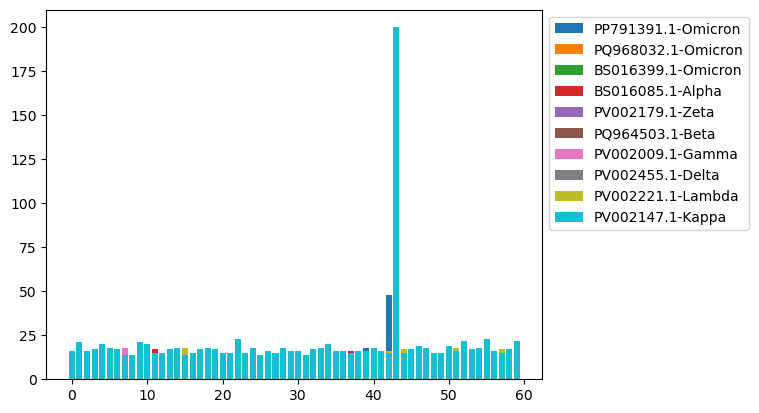

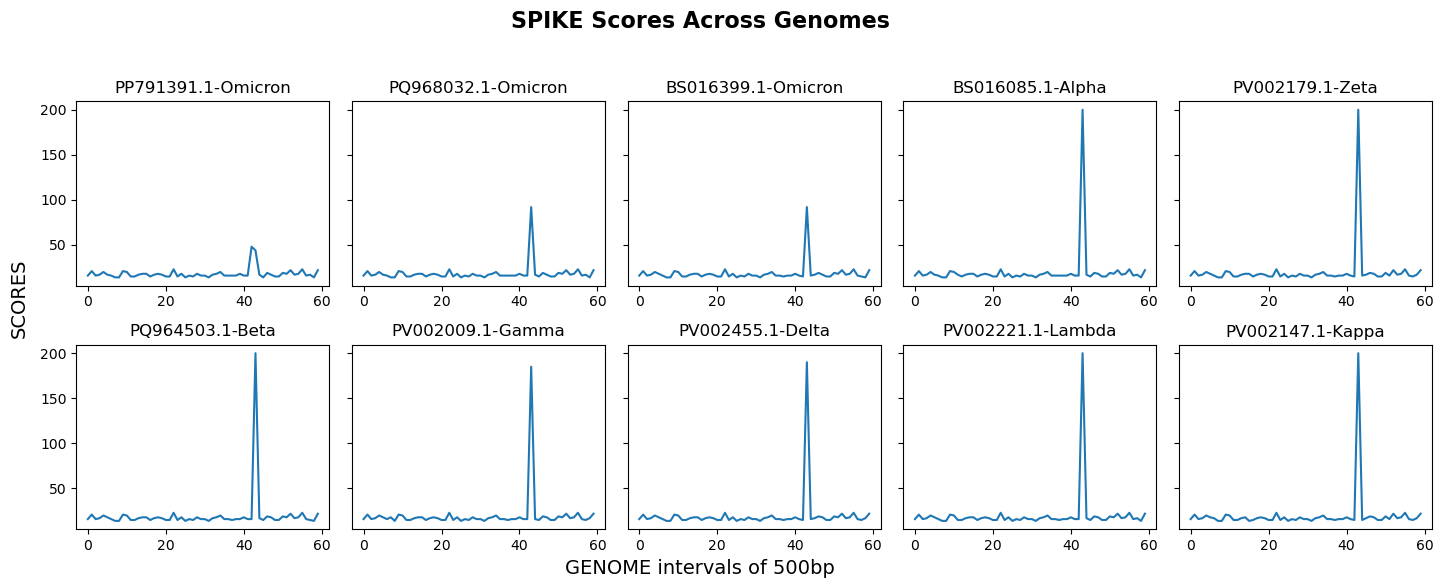

In [19]:
geneInGenomes=findGene(gene_seq, genomes, protein='SPIKE')

In [20]:
print(geneInGenomes)

[Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCGC...CTC'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCGC...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTCATGCCAC...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATTTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTTTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA'), Seq('TGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTA...TAA')]


## STEP 3

Perform a multiple sequence alignment

In [22]:
def fileName(name):
    file_name= name
    return file_name

In [23]:
file_name=fileName('local_spike')

In [24]:
def checkDuplicates(file_name):
    if os.path.exists(file_name +'.fasta'):
        os.remove(file_name + '.fasta')
    if os.path.exists(file_name +'.aln'):
        os.remove(file_name + '.aln')
    if os.path.exists(file_name +'.phylip'):
        os.remove(file_name + '.phylip')
    if os.path.exists(file_name +'.phylip_phyml_stats'):
        os.remove(file_name + '.phylip_phyml_stats')
    if os.path.exists(file_name +'.phylip_phyml_tree'):
        os.remove(file_name + '.phylip_phyml_tree')

In [25]:
def local_msa(geneInGenomes, genomes, file_name):
    m_genomes=copy.deepcopy(genomes)
    i=0
    for genome in m_genomes:
        genome.seq=geneInGenomes[i]
        i+=1
    local_fasta=file_name +'.fasta'
    checkDuplicates(file_name)
    with open(local_fasta, 'w') as f:
        SeqIO.write(m_genomes, f, format='fasta')
    try:
        clustalw_exe = r"C:\Program Files (x86)\ClustalW2\clustalw2.exe" 
        input_file = local_fasta
        command = [clustalw_exe, "-INFILE=" + input_file]
        result = subprocess.run(command, capture_output=True, text=True)
        if result.returncode == 0:
            print("ClustalW (msa) success!")

    except Exception as exc:
        print(f"Error running ClustalW, {exc} error")
        print(result.stderr) 

In [26]:
local_msa(geneInGenomes, genomes,file_name)

ClustalW (msa) success!


## STEP 4

Create the phylogenetic tree

In [28]:
def tree_generation(file_name, protein):
    try:
        msa=AlignIO.read(file_name+'.aln',format='clustal')
        AlignIO.write(msa,file_name+ '.phylip',format='phylip')
        cmnd=PhymlCommandline(cmd=r"C:\Users\Silvio\OneDrive - University of Pisa\Desktop\PhyML-3.1\PhyML-3.1.exe",input=file_name+'.phylip',datatype='nt')
        cmnd()
        tree=Phylo.read(file_name+'.phylip_phyml_tree.txt',format='newick')
        leaves = tree.get_terminals()
        for i, leaf in enumerate(leaves):
            leaf.name = f'{genomes[i].name}'
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.set_title(f"Phylogenetic Tree based on {protein} evolution", fontsize=13, fontweight="bold")
        Phylo.draw(tree, axes=ax)
        plt.show()
        print('Phylo generation success!')
    except Exception as exc:
        print(f'"{exc}" error has occur')

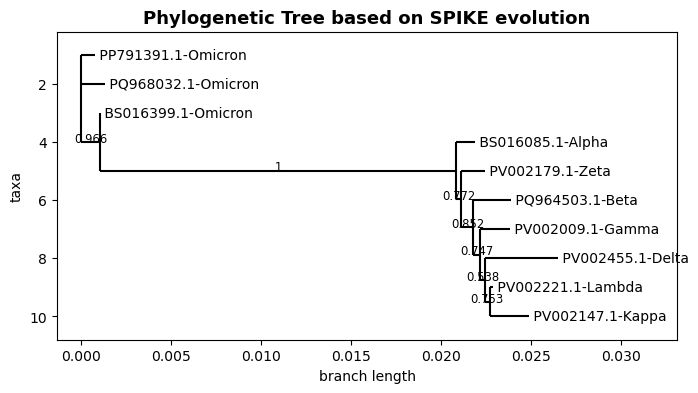

Phylo generation success!


In [29]:
tree_generation(file_name, protein='SPIKE')

## STEP 5

Create a Pipeline


In [31]:
def project_Pipeline(gene_file, genomes_file,low_inter, up_inter,myfile, protein, genomes_names):
    gene_seq=getGene(gene_file, low_inter, up_inter)
    genomes_ids=readGenomes(genomes_file)
    genomes=getGenomes(genomes_ids)
    getGenomes_names(genomes, genomes_names)
    geneInGenomes=findGene(gene_seq,genomes, protein)
    file_name=fileName(myfile)
    local_msa(geneInGenomes, genomes, file_name)
    tree_generation(file_name, protein)

# **SPIKE**

Reading from file success!
Gene uploading success!
Genomes uploading success!
Genomes named correctly!
"PP791391.1-Omicron" genome, found between: 20800 - 25021 of length: 4221
found a gene of length: 3545
"PQ968032.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3806
"BS016399.1-Omicron" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3809
"BS016085.1-Alpha" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002179.1-Zeta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PQ964503.1-Beta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3812
"PV002009.1-Gamma" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3821
"PV002455.1-Delta" genome, found between: 21300 - 25521 of length: 4221
found a gene of length: 3815
"PV002221.1-Lambda" genome, found between: 21300 - 25521 of length: 4221
found a gene

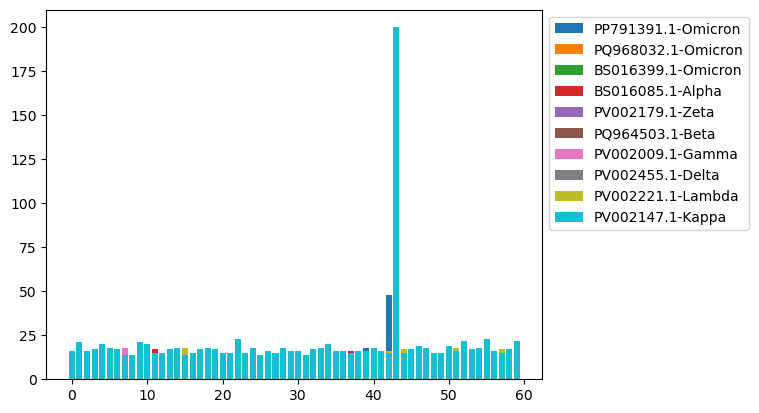

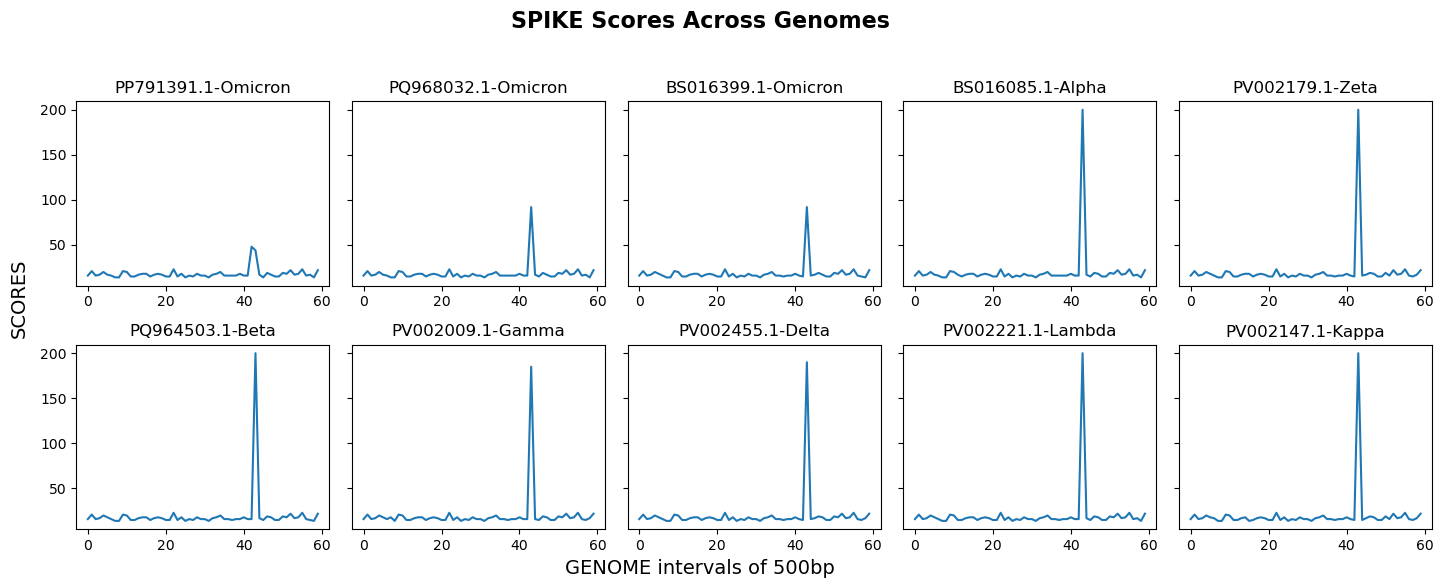

ClustalW (msa) success!


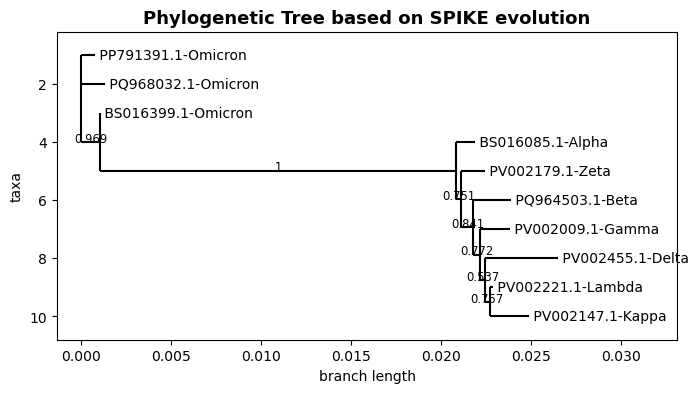

Phylo generation success!


In [33]:
project_Pipeline('SARS-CoV-2_genome.csv', 'SARS-CoV-2_variants.csv',21563,25384, 'local_spike', 'SPIKE',
                genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])

# **NUCLEOCAPSID**

Reading from file success!
Gene uploading success!
Genomes uploading success!
Genomes named correctly!
"PP791391.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1250
"PQ968032.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1250
"BS016399.1-Omicron" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1238
"BS016085.1-Alpha" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1258
"PV002179.1-Zeta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1228
"PQ964503.1-Beta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1247
"PV002009.1-Gamma" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1234
"PV002455.1-Delta" genome, found between: 27800 - 29459 of length: 1659
found a gene of length: 1236
"PV002221.1-Lambda" genome, found between: 27800 - 29459 of length: 1659
found a gene

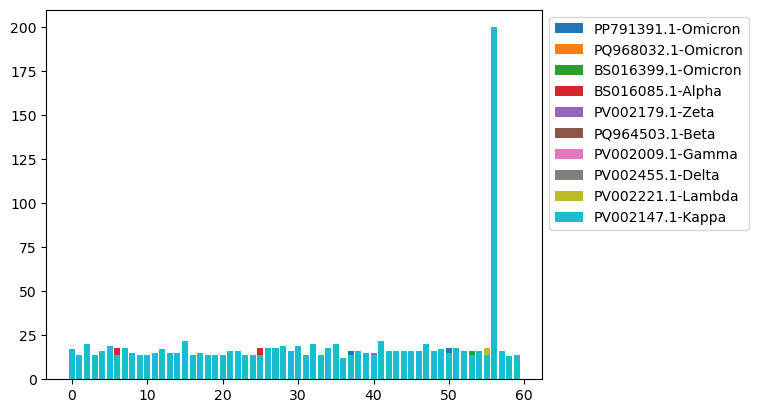

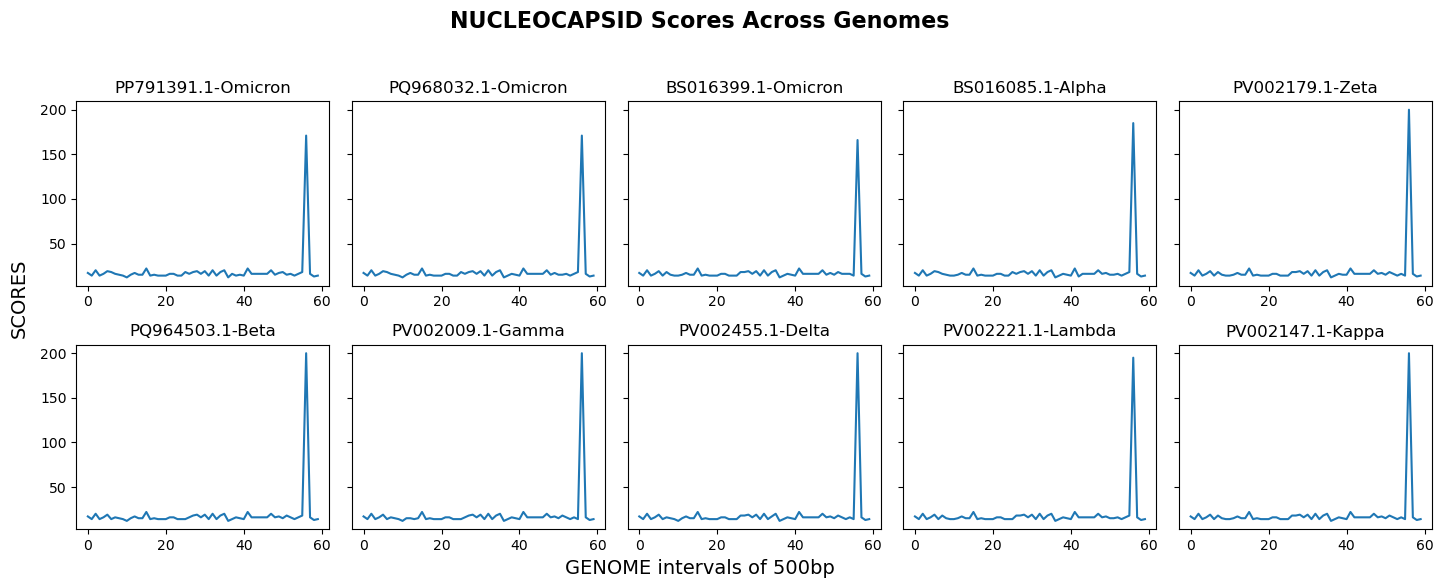

ClustalW (msa) success!


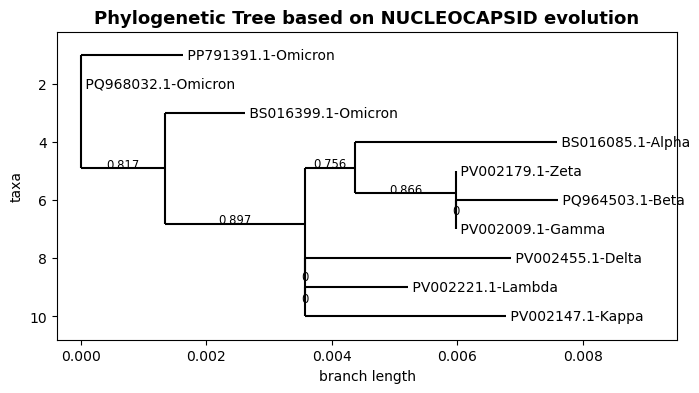

Phylo generation success!


In [35]:
project_Pipeline('SARS-CoV-2_genome.csv', 'SARS-CoV-2_variants.csv',28274,29533, 'local_N','NUCLEOCAPSID', 
                 genomes_names=['Omicron', 'Omicron', 'Omicron', 'Alpha', 'Zeta', 'Beta', 'Gamma', 'Delta', 'Lambda', 'Kappa'])